In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def clr(lr_min,lr_max,x):
  """ return lr rate at a x """
  lr = lr_min + (lr_max-lr_min) * (1-x)
  return lr

def fn_x(iteration, stepsize):
  """ get x for iteration at stepsize"""
  cycle = np.floor(1+(iteration/stepsize)/2)
  temp = (iteration/stepsize) - 2* cycle + 1
  x = np.abs(temp)
  return x

In [3]:
x = []
y = [] 

for i in range(1,2000):
  t = fn_x(iteration=i, stepsize=500)
  x.append(t)
  y.append(clr(lr_min=.01,lr_max=.1,x=t))

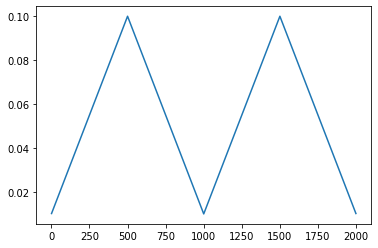

In [4]:
plt.plot(range(1,2000),y)

In [2]:
cd D:/ML/EVA/JEDi/tsai.jedi

D:\ML\EVA\JEDi\tsai.jedi


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import sys
sys.path.append('D:/ML/EVA/JEDI/tsai.jedi/Models')
from s11_Davidnet import s11_david
from S9_resnet import resnet18,resnet50
from S7 import model_summary
from lr_finder import LRFinder
import torch.nn as nn
from dataloader import test_loader_CIFAR10_alb, train_loader_CIFAR10_s11
from aftereffects import get_image_with_target, plots
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
import config

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_loader_CIFAR10_s11)

98

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ResNet(nn.Module):

    def __init__(self,  num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        
        ############## basic block1 ###############
        in_planes = 128
        self.bconv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1,
                     padding=1)
        self.bbn1 = nn.BatchNorm2d(in_planes)
        self.bconv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1,
                     padding=1)
        self.bbn2 = nn.BatchNorm2d(in_planes)
        ############## basic block2 ###############
        in_planes2 = 512
        self.bconv3 = nn.Conv2d(in_planes2, in_planes2, kernel_size=3, stride=1,
                     padding=1)
        self.bbn3 = nn.BatchNorm2d(in_planes2)
        self.bconv4 = nn.Conv2d(in_planes2, in_planes2, kernel_size=3, stride=1,
                     padding=1)
        self.bbn4 = nn.BatchNorm2d(in_planes2)
        ################################################

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inplanes2 = 128
        self.conv2 = nn.Conv2d(64, self.inplanes2, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(self.inplanes2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inplanes3 = 256
        self.conv3 = nn.Conv2d(128, self.inplanes3, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(self.inplanes3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inplanes4 = 512
        self.conv4 = nn.Conv2d(256, self.inplanes4, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn4 = nn.BatchNorm2d(self.inplanes4)
        self.maxpool4 = nn.MaxPool2d(kernel_size=4, stride=1)
        
        self.fc = nn.Linear(512 , num_classes)


    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        #layer1
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.bn2(x)
        x = F.relu(x)
        

        identity = x

        out = self.bconv1(x)
        out = self.bbn1(out)
        out = F.relu(out)

        out = self.bconv2(out)
        out = self.bbn2(out)
        out = F.relu(out)

        out += identity
        x =  out
        #layer2
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.bn3(x)
        x = F.relu(x)

        #layer 3
        x = self.conv4(x)
        x = self.maxpool3(x)
        x = self.bn4(x)
        x = F.relu(x)

        identity = x

        out = self.bconv3(x)
        out = self.bbn3(out)
        out = F.relu(out)

        out = self.bconv4(out)
        out = self.bbn4(out)
        out = F.relu(out)

        out += identity
        x =  out

        x = self.maxpool4(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)
        return x

    def forward(self, x):
        return self._forward_impl(x)

In [7]:
#model_ = resnet18(num_classes=10, pretrained=False).to(config.device)
model_ = ResNet().to(config.device)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.72E-05


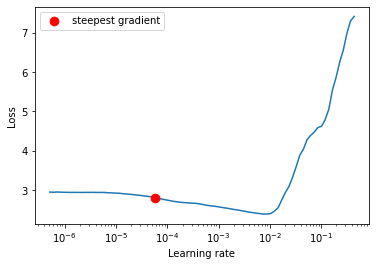

In [8]:
#model_ = ResNet().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_s11, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [32]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from Engine_train_test import train_cyclic, test
optimizer = optim.SGD(model_.parameters(), lr=9.33E-02, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer,max_lr=9.33E-02,epochs = 24,steps_per_epoch = len(train_loader_CIFAR10_s11),
                       pct_start = 0.21,div_factor = 10,final_div_factor = 1)
valid_acc = []
valid_loss = []
train_acc = []
train_loss = []
for epoch in range(1, 25):
    train_a, train_l = train_cyclic(model_, config.device, train_loader_CIFAR10_s11, optimizer, epoch,
                             is_cyclicLR = True,scheduler = scheduler,l1_regularization=[0, 1])
    train_acc.append(train_a)
    train_loss.append(train_l)
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb) 
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    train_loss.append(valid_l)




Epoch: 1,LR: 0.017256802766108664.
Train set: train Average loss: 1.6443, train_Accuracy: 18353/50000 (36.7060%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4755/10000 (47.5500%)



Epoch: 2,LR: 0.03804403721221181.
Train set: train Average loss: 1.8898, train_Accuracy: 20842/50000 (41.6840%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 4373/10000 (43.7300%)



Epoch: 3,LR: 0.06384240918529671.
Train set: train Average loss: 1.2200, train_Accuracy: 25108/50000 (50.2160%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 5902/10000 (59.0200%)



Epoch: 4,LR: 0.08491041070311497.
Train set: train Average loss: 1.1747, train_Accuracy: 28485/50000 (56.9700%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 6073/10000 (60.7300%)



Epoch: 5,LR: 0.09329272950139014.
Train set: train Average loss: 0.8618, train_Accuracy: 31946/50000 (63.8920%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6876/10000 (68.7600%)



Epoch: 6,LR: 0.09275865026137027.
Train set: train Average loss: 1.1219, train_Accuracy: 34333/50000 (68.6660%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 7210/10000 (72.1000%)



Epoch: 7,LR: 0.09108257342337629.
Train set: train Average loss: 0.8222, train_Accuracy: 35613/50000 (71.2260%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7778/10000 (77.7800%)



Epoch: 8,LR: 0.0883171694798904.
Train set: train Average loss: 0.7140, train_Accuracy: 37584/50000 (75.1680%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7840/10000 (78.4000%)



Epoch: 9,LR: 0.08453818933080287.
Train set: train Average loss: 0.6732, train_Accuracy: 38362/50000 (76.7240%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7742/10000 (77.4200%)



Epoch: 10,LR: 0.07984914810548029.
Train set: train Average loss: 0.5905, train_Accuracy: 39131/50000 (78.2620%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8284/10000 (82.8400%)



Epoch: 11,LR: 0.07437848964059163.
Train set: train Average loss: 0.6899, train_Accuracy: 39843/50000 (79.6860%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8339/10000 (83.3900%)



Epoch: 12,LR: 0.06827606810217432.
Train set: train Average loss: 0.5320, train_Accuracy: 40530/50000 (81.0600%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8114/10000 (81.1400%)



Epoch: 13,LR: 0.06170904312856394.
Train set: train Average loss: 0.4978, train_Accuracy: 40613/50000 (81.2260%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8365/10000 (83.6500%)



Epoch: 14,LR: 0.0548573009358501.
Train set: train Average loss: 0.5132, train_Accuracy: 41402/50000 (82.8040%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8507/10000 (85.0700%)



Epoch: 15,LR: 0.04790852681251907.
Train set: train Average loss: 0.4205, train_Accuracy: 41879/50000 (83.7580%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8458/10000 (84.5800%)



Epoch: 16,LR: 0.04105306397921193.
Train set: train Average loss: 0.4146, train_Accuracy: 42398/50000 (84.7960%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8709/10000 (87.0900%)



Epoch: 17,LR: 0.03447869964148703.
Train set: train Average loss: 0.4392, train_Accuracy: 42741/50000 (85.4820%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8768/10000 (87.6800%)



Epoch: 18,LR: 0.02836552105783058.
Train set: train Average loss: 0.3862, train_Accuracy: 43386/50000 (86.7720%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8839/10000 (88.3900%)



Epoch: 19,LR: 0.022880982527276432.
Train set: train Average loss: 0.2843, train_Accuracy: 43559/50000 (87.1180%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8874/10000 (88.7400%)



Epoch: 20,LR: 0.018175318423414404.
Train set: train Average loss: 0.3454, train_Accuracy: 44162/50000 (88.3240%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8900/10000 (89.0000%)



Epoch: 21,LR: 0.014377427922543333.
Train set: train Average loss: 0.2890, train_Accuracy: 44495/50000 (88.9900%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8951/10000 (89.5100%)



Epoch: 22,LR: 0.011591344152916846.
Train set: train Average loss: 0.3230, train_Accuracy: 44819/50000 (89.6380%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9061/10000 (90.6100%)



Epoch: 23,LR: 0.009893384483364926.
Train set: train Average loss: 0.3085, train_Accuracy: 45109/50000 (90.2180%)


Test set: Average loss: 0.0007, Accuracy: 8955/10000 (89.5500%)



# New iteration

In [15]:
model_ = s11_david().to(config.device)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.43E-01


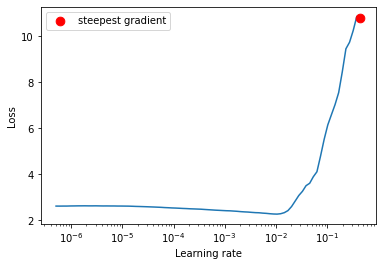

In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_s11, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [16]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from Engine_train_test import train_cyclic, test
optimizer = optim.SGD(model_.parameters(), lr=9.9E-02, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer,max_lr=9.9E-02,epochs = 24,steps_per_epoch = len(train_loader_CIFAR10_s11),
                       pct_start = 0.21,div_factor = 10,final_div_factor = 1)
valid_acc = []
valid_loss = []
train_acc = []
train_loss = []
for epoch in range(1, 25):
    train_a, train_l = train_cyclic(model_, config.device, train_loader_CIFAR10_s11, optimizer, epoch,
                             is_cyclicLR = True,scheduler = scheduler,l1_regularization=[0, 1])
    train_acc.append(train_a)
    train_loss.append(train_l)
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb) 
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    train_loss.append(valid_l)

Epoch: 1,LR: 0.018311076890083156.
Train set: train Average loss: 3.4248, train_Accuracy: 6953/50000 (13.9060%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 1538/10000 (15.3800%)



Epoch: 2,LR: 0.04036827099688071.
Train set: train Average loss: 2.8867, train_Accuracy: 10195/50000 (20.3900%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 2758/10000 (27.5800%)



Epoch: 3,LR: 0.06774274929629556.
Train set: train Average loss: 2.0185, train_Accuracy: 11930/50000 (23.8600%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 3400/10000 (34.0000%)



Epoch: 4,LR: 0.0900978634470352.
Train set: train Average loss: 1.8737, train_Accuracy: 16738/50000 (33.4760%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4232/10000 (42.3200%)



Epoch: 5,LR: 0.09899228532301849.
Train set: train Average loss: 1.5459, train_Accuracy: 21353/50000 (42.7060%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5087/10000 (50.8700%)



Epoch: 6,LR: 0.09842557744775625.
Train set: train Average loss: 1.3308, train_Accuracy: 25313/50000 (50.6260%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5439/10000 (54.3900%)



Epoch: 7,LR: 0.09664710363252148.
Train set: train Average loss: 1.1911, train_Accuracy: 28957/50000 (57.9140%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6462/10000 (64.6200%)



Epoch: 8,LR: 0.0937127521812342.
Train set: train Average loss: 0.9334, train_Accuracy: 31560/50000 (63.1200%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6931/10000 (69.3100%)



Epoch: 9,LR: 0.08970290186226672.
Train set: train Average loss: 0.9053, train_Accuracy: 34050/50000 (68.1000%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7081/10000 (70.8100%)



Epoch: 10,LR: 0.08472739188041319.
Train set: train Average loss: 0.8978, train_Accuracy: 35555/50000 (71.1100%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7558/10000 (75.5800%)



Epoch: 11,LR: 0.07892251312345737.
Train set: train Average loss: 0.6890, train_Accuracy: 37289/50000 (74.5780%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7666/10000 (76.6600%)



Epoch: 12,LR: 0.0724472748351046.
Train set: train Average loss: 0.6472, train_Accuracy: 38125/50000 (76.2500%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7718/10000 (77.1800%)



Epoch: 13,LR: 0.06547904897886207.
Train set: train Average loss: 0.5478, train_Accuracy: 39089/50000 (78.1780%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8142/10000 (81.4200%)



Epoch: 14,LR: 0.0582087116039567.
Train set: train Average loss: 0.5785, train_Accuracy: 39566/50000 (79.1320%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8032/10000 (80.3200%)



Epoch: 15,LR: 0.05083541430267298.
Train set: train Average loss: 0.5794, train_Accuracy: 40418/50000 (80.8360%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8318/10000 (83.1800%)



Epoch: 16,LR: 0.043561128981157354.
Train set: train Average loss: 0.4535, train_Accuracy: 40989/50000 (81.9780%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8479/10000 (84.7900%)



Epoch: 17,LR: 0.03658511537521132.
Train set: train Average loss: 0.5162, train_Accuracy: 41595/50000 (83.1900%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8352/10000 (83.5200%)



Epoch: 18,LR: 0.030098462858791294.
Train set: train Average loss: 0.4614, train_Accuracy: 41904/50000 (83.8080%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8528/10000 (85.2800%)



Epoch: 19,LR: 0.024278856057881746.
Train set: train Average loss: 0.5041, train_Accuracy: 42572/50000 (85.1440%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8790/10000 (87.9000%)



Epoch: 20,LR: 0.01928570765185451.
Train set: train Average loss: 0.3640, train_Accuracy: 43056/50000 (86.1120%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8774/10000 (87.7400%)



Epoch: 21,LR: 0.0152557916863.
Train set: train Average loss: 0.3471, train_Accuracy: 43569/50000 (87.1380%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8879/10000 (88.7900%)



Epoch: 22,LR: 0.012299497011133632.
Train set: train Average loss: 0.3944, train_Accuracy: 44016/50000 (88.0320%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8864/10000 (88.6400%)



Epoch: 23,LR: 0.010497803471094616.
Train set: train Average loss: 0.2946, train_Accuracy: 44389/50000 (88.7780%)



  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8922/10000 (89.2200%)



Epoch: 24,LR: 0.009900063677871359.
Train set: train Average loss: 0.2882, train_Accuracy: 44616/50000 (89.2320%)


Test set: Average loss: 0.0006, Accuracy: 8939/10000 (89.3900%)

